In [2]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def HMC(mu=0.0,sigma=1.0,path_len=1,step_size=0.25,initial_position=0.0,epochs=1_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    samples = [initial_position]
    momentum_dist = st.norm(0, 1) 
    # generate samples
    for e in range(epochs):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        dVdQ = -1*(q0-mu)/(sigma**2) # gradient of PDF wrt position (q0) aka potential energy wrt position

        # leapfrog integration begin
        for s in range(steps): 
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum 
            p1 += step_size*dVdQ/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        p1 = -1*p1 #flip momentum for reversibility     

        
        #metropolis acceptance
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0,sigma=1)
        p1_nlp = neg_log_prob(x=p1,mu=0,sigma=1)
        
        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p1)/P(p0)
        acceptance = target + adjustment 
        
        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)
    
    return samples   

(array([0.00682039, 0.        , 0.00454693, 0.01591424, 0.02500809,
        0.07047735, 0.13640777, 0.21370551, 0.30691748, 0.45469257,
        0.37284791, 0.32965211, 0.15004855, 0.10230583, 0.04546926,
        0.00909385, 0.0181877 , 0.00682039, 0.00454693, 0.00227346]),
 array([-4.30652953, -3.86711131, -3.42769308, -2.98827486, -2.54885664,
        -2.10943842, -1.67002019, -1.23060197, -0.79118375, -0.35176553,
         0.08765269,  0.52707092,  0.96648914,  1.40590736,  1.84532558,
         2.28474381,  2.72416203,  3.16358025,  3.60299847,  4.04241669,
         4.48183492]),
 <BarContainer object of 20 artists>)

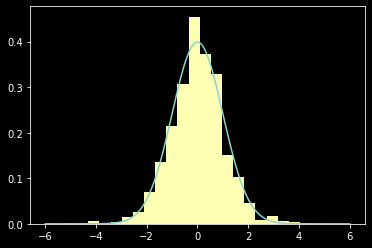

In [10]:
import matplotlib.pyplot as plt
mu = 0
sigma = 1
trial = HMC(mu=mu,sigma=sigma,path_len=1.5,step_size=0.25)

lines = np.linspace(-6,6,10000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines, normal_curve)
plt.hist(np.array(trial), density=True, bins=20)